# Execution Interval Method

In [2]:
import json
import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import defaultdict
from libraries.utils import *
from libraries.exeint import exeInt




## Load Data

In [3]:
############ configuration ################
############################################

CODE = 'theft_protection'       ### application (code)
BEHAVIOUR_FAULTY = 'faulty_data'            ### normal, faulty_data
BEHAVIOUR_NORMAL = 'normal'            ### normal, faulty_data
THREAD = 'single'           ### single, multi
VER = 3                     ### format of data collection

base_dir = '../trace_data' ### can be replaced with 'csv', 'exe_plot', 'histogram'
normalbase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_NORMAL}'
faultybase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_FAULTY}'

print(normalbase_path)
print(faultybase_path)

../trace_data/theft_protection/single_thread/version_3/normal
../trace_data/theft_protection/single_thread/version_3/faulty_data


In [4]:

train_base_path = os.path.join(normalbase_path, 'train_data')
train_data_path = [os.path.join(train_base_path, x) for x in os.listdir(train_base_path)]

######### get paths #######################
paths_log, paths_traces, varlist_path, paths_label = get_paths(faultybase_path)

### remove.Ds_store from all lists
train_data_path = [x for x in train_data_path if '.DS_Store' not in x]
paths_log = [x for x in paths_log if '.DS_Store' not in x]
paths_traces = [x for x in paths_traces if '.DS_Store' not in x]
varlist_path = [x for x in varlist_path if '.DS_Store' not in x]
paths_label = [x for x in paths_label if '.DS_Store' not in x]

paths_log.sort()
paths_traces.sort()
varlist_path.sort()
paths_label.sort()

# print(paths_log)
# print(paths_traces)
# print(varlist_path)
# print(paths_label)

test_data_path = paths_traces
test_label_path = paths_label

print(train_data_path)
print(test_data_path)
print(test_label_path)


['../trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_1250_2000.json', '../trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_2050_2300.json', '../trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_150_900.json', '../trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_0_110.json']
['../trace_data/theft_protection/single_thread/version_3/faulty_data/trace_trial1', '../trace_data/theft_protection/single_thread/version_3/faulty_data/trace_trial2', '../trace_data/theft_protection/single_thread/version_3/faulty_data/trace_trial3']
['../trace_data/theft_protection/single_thread/version_3/faulty_data/labels/trace_trial1_labels.json', '../trace_data/theft_protection/single_thread/version_3/faulty_data/labels/trace_trial2_labels.json', '../trace_data/theft_protection/single_thread/version_3/faulty_data/labels/trace_trial3_labels.json']


In [5]:
varlist_path

['../trace_data/theft_protection/single_thread/version_3/faulty_data/varlist_trial1.json',
 '../trace_data/theft_protection/single_thread/version_3/faulty_data/varlist_trial2.json',
 '../trace_data/theft_protection/single_thread/version_3/faulty_data/varlist_trial3.json']

In [6]:
############# check varlist is consistent ############
############# only for version 3 ######################

if VER == 3:
    to_number = is_consistent(varlist_path)

    if to_number != False:
        from_number = mapint2var(to_number)


varlist 1 is consistent with varlist 0
{'1-0-main-g_ack': 13, '1-control-update_txmsg-0': 12, '1-0-main-lora': 2, '1-0-main-temperature': 8, '1-0-main-ow': 0, '1-0-main-events': 14, '1-0-main-com_timer': 4, '1-control-update_rxmsg-drop': 15, '1-0-loracom-data': 11, '1-control-readdata-0': 10, '1-0-main-temp': 1, '1-0-main-s': 3, '1-control-updatedata-cls.sensor_data': 9, '1-0-sense-temperature': 7, '1-0-main-i': 6, '1-control-init_timer0-0': 5} {'1-0-main-g_ack': 13, '1-control-update_txmsg-0': 12, '1-0-main-lora': 2, '1-0-main-temperature': 8, '1-0-main-ow': 0, '1-0-main-events': 14, '1-0-main-com_timer': 4, '1-control-update_rxmsg-drop': 15, '1-0-loracom-data': 11, '1-control-readdata-0': 10, '1-0-main-temp': 1, '1-0-main-s': 3, '1-control-updatedata-cls.sensor_data': 9, '1-0-sense-temperature': 7, '1-0-main-i': 6, '1-control-init_timer0-0': 5}


In [ ]:
#### key finder ####
from_number[44]

In [7]:
############ Get variable list ######################
sorted_keys = list(from_number.keys())
sorted_keys.sort()
var_list = [from_number[key] for key in sorted_keys]   ### get the variable list
# print(var_list)

## Confidence Interval

__Confidence Interval:__

A confidence interval is a range around the mean that is likely to contain the true population mean. The formula for a confidence interval is mean ± margin of error mean±margin of error, where the margin of error depends on the desired confidence level and the standard error.

_Example:_

1. Choose a confidence level (e.g., 95%).
2. Calculate the standard error: standard deviation/ sqr_root(number of observations)
3. Calculate the margin of error: critical value × standard error
4. Determine the confidence interval: mean ± margin of error


In [8]:
### initialize exeinz
ei = exeInt()

### Data Processing

In [9]:
### get execution intervals for all variables

exe_list, filewise_exe_list = ei.get_exeint(train_data_path)

../trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_1250_2000.json
../trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_1250_2000.json
dict_keys([13, 14, 15, 6, 7, 8, 9, 10, 11, 12])
13 253738 257970
13 257970 263253
13 263253 268536
13 268536 273818
13 273818 278049
13 278049 283332
13 283332 288613
13 288613 293898
13 293898 298131
13 298131 303414
13 303414 308697
13 308697 312929
13 312929 318213
13 318213 323495
13 323495 328781
13 328781 333012
13 333012 338295
13 338295 343579
13 343579 348864
13 348864 353097
13 353097 358381
13 358381 363664
13 363664 367898
13 367898 373183
13 373183 378469
13 378469 383751
13 383751 387987
13 387987 393270
13 393270 398554
13 398554 403839
14 253743 257974
14 257974 263257
14 263257 268540
14 268540 273822
14 273822 278053
14 278053 283337
14 283337 288619
14 288619 293903
14 293903 298135
14 298135 303418
14 303418 308701
14 308701 312934
14 312934 318217
14 318217 323500
14 323500 

In [10]:
for k in list(exe_list.keys()):
    print(k, len(exe_list[k]))

13 71
14 71
15 70
6 347
7 348
8 348
9 348
10 71
11 70
12 70
0 3
1 3
2 3
3 3
4 3
5 3


In [11]:
################## methods to detect outliers based on execution intervals ####################

############ calculate dynamic thresholds ############
thresholds = ei.get_dynamicthresh(exe_list)

############ train lof model ################
lof_models = ei.train_lof(exe_list)

13
value: 4.2 prob: 0.28169014084507044
value: 5.3 prob: 0.7183098591549296
14
value: 4.2 prob: 0.28169014084507044
value: 5.3 prob: 0.7183098591549296
15
value: 4.2 prob: 0.2857142857142857
value: 5.3 prob: 0.7142857142857143
6
value: 1.1 prob: 1.0
7
value: 1.1 prob: 1.0
8
value: 1.1 prob: 1.0
9
value: 1.1 prob: 1.0
10
value: 4.2 prob: 0.2676056338028169
value: 5.3 prob: 0.7323943661971831
11
value: 4.2 prob: 0.2714285714285714
value: 5.3 prob: 0.7285714285714285
12
value: 4.2 prob: 0.2714285714285714
value: 5.3 prob: 0.7285714285714285
0
value: 0.0 prob: 1.0
1
value: 0.0 prob: 1.0
2
value: 0.0 prob: 1.0
3
value: 0.0 prob: 1.0
4
value: 0.0 prob: 1.0
5
value: 0.0 prob: 1.0
Unique values: 13 defaultdict(<class 'list'>, {4.2: 0.28169014084507044, 5.3: 0.7183098591549296})
Unique values: 14 defaultdict(<class 'list'>, {4.2: 0.28169014084507044, 5.3: 0.7183098591549296})
Unique values: 15 defaultdict(<class 'list'>, {4.2: 0.2857142857142857, 5.3: 0.7142857142857143})
Unique values: 6 defau

In [12]:
thresholds

{13: [4.1, 5.4],
 14: [4.1, 5.4],
 15: [4.1, 5.4],
 6: [1.0, 1.2],
 7: [1.0, 1.2],
 8: [1.0, 1.2],
 9: [1.0, 1.2],
 10: [4.1, 5.4],
 11: [4.1, 5.4],
 12: [4.1, 5.4],
 0: [0.0, 0.1],
 1: [0.0, 0.1],
 2: [0.0, 0.1],
 3: [0.0, 0.1],
 4: [0.0, 0.1],
 5: [0.0, 0.1]}

In [13]:
lof_models

{13: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 14: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 15: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 6: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 7: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 8: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 9: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 10: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 11: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 12: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 0: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 1: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 2: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 3: LocalOutlierFactor(contamination=0.01, n_

In [14]:
### visualize the thresholds for varlist
for key in thresholds.keys():
    print(from_number[key], ':', end=' ')
    print(thresholds[key], end=', ')
    print('\n')

1-0-main-g_ack : [4.1, 5.4], 

1-0-main-events : [4.1, 5.4], 

1-control-update_rxmsg-drop : [4.1, 5.4], 

1-0-main-i : [1.0, 1.2], 

1-0-sense-temperature : [1.0, 1.2], 

1-0-main-temperature : [1.0, 1.2], 

1-control-updatedata-cls.sensor_data : [1.0, 1.2], 

1-control-readdata-0 : [4.1, 5.4], 

1-0-loracom-data : [4.1, 5.4], 

1-control-update_txmsg-0 : [4.1, 5.4], 

1-0-main-ow : [0.0, 0.1], 

1-0-main-temp : [0.0, 0.1], 

1-0-main-lora : [0.0, 0.1], 

1-0-main-s : [0.0, 0.1], 

1-0-main-com_timer : [0.0, 0.1], 

1-control-init_timer0-0 : [0.0, 0.1], 



### Visualising Thresholds

In [15]:
### plot exe_list to vsiualize the distribution of execution intervals
# ei.viz_thresholds(exe_list, thresholds=thresholds)


### Validation

In [16]:
#### Detect anomalies in faulty traces
DIFF_VAL = 5.0
all_tp = []
all_fp = []
all_detections = [] ### format [file1_detection, file2_detection] -> file1_detection: [(state1, 0), (ts1, ts2), filename]  
all_group_detections = [] ### format [file1_detection, file2_detection] -> file1_detection: [(state1, 0), (ts1, ts2), filename]
all_merged_detections = [] ### format [file1_detection, file2_detection] -> file1_detection: [(state1, 0), (ts1, ts2), filename]
y_pred_all = []
y_true_all = []
for test_data, test_label in zip(test_data_path, test_label_path):
    print(test_data, test_label)

    detection = ei.test_single(test_data, thresholds=thresholds)   ### detection in format: [var, (ts1,ts2), file_name]     ### threshold based detection
    # detection = ei.test_single(test_data, lof_models=lof_models)   ### detection in format: [var, (ts1,ts2), file_name]    ### lof based detection

    merged_detection, grouped_det = ei.merge_detections(detection, DIFF_VAL)  ### merge detections for multiple variables
    detection = merged_detection
    # dedup_detection, grouped_det = ei.remove_duplicates(detection, DIFF_VAL)  ### remove multiple detections for single ground truth
    # detection = dedup_detection

    all_detections += [(test_data, detection, test_label)]  ### used to plot detections
    all_group_detections += [(test_data, grouped_det, test_label)]  ### used to plot grouped detections
    all_merged_detections += [(test_data, merged_detection, test_label)]  ### used to plot merged detections

    ### load ground truths
    ground_truth_raw = read_traces(test_label)
    ground_truth = ground_truth_raw['labels']
    label_trace_name = list(ground_truth.keys())[0]
    ground_truth = ground_truth[label_trace_name]
    print('ground truths:', ground_truth)
    print(len(ground_truth))

    # correct_pred, rest_pred, y_pred, y_true = get_ypred_ytrue(detection, ground_truth)  ### case1_pred, case2_pred, case34_pred, rest_pred
    correct_pred, rest_pred, y_pred, y_true = ei.get_correct_detections(detection, ground_truth)  ### case1_pred, case2_pred, case34_pred, rest_pred

    assert( len(detection) == len(correct_pred) + len(rest_pred) )

    all_tp += [(test_data, correct_pred, test_label)]
    all_fp += [(test_data, rest_pred, test_label)]

    y_pred_all.extend(y_pred)
    y_true_all.extend(y_true)

    # break

../trace_data/theft_protection/single_thread/version_3/faulty_data/trace_trial1 ../trace_data/theft_protection/single_thread/version_3/faulty_data/labels/trace_trial1_labels.json
Anomaly detected for 13 in trace_trial1 at 227th event
Execution interval: 14.8
Anomaly detected for 14 in trace_trial1 at 228th event
Execution interval: 14.8
Anomaly detected for 15 in trace_trial1 at 229th event
Execution interval: 14.8
Anomaly detected for 13 in trace_trial1 at 350th event
Execution interval: 10.6
Anomaly detected for 14 in trace_trial1 at 351th event
Execution interval: 10.6
Anomaly detected for 15 in trace_trial1 at 352th event
Execution interval: 10.6
Anomaly detected for 13 in trace_trial1 at 447th event
Execution interval: 10.6
Anomaly detected for 14 in trace_trial1 at 448th event
Execution interval: 10.6
Anomaly detected for 15 in trace_trial1 at 449th event
Execution interval: 10.6
Anomaly detected for 13 in trace_trial1 at 563th event
Execution interval: 14.8
Anomaly detected for 

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[46]]


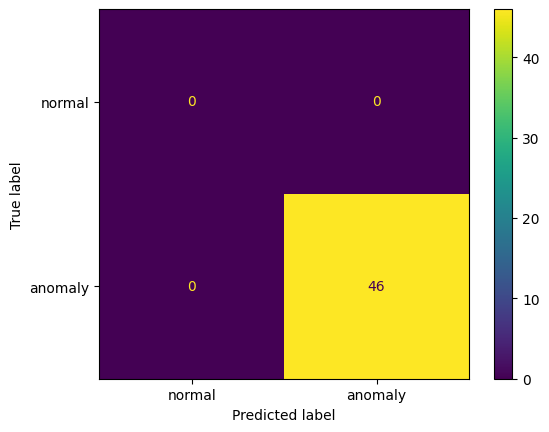

In [17]:
### Evaluation metrics

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, average_precision_score, ConfusionMatrixDisplay


# Calculate precision
precision = precision_score(y_true_all, y_pred_all)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_true_all, y_pred_all)
print(f'Recall: {recall:.4f}')

# # Calculate average precision
# average_precision = average_precision_score(y_true_all, y_pred_all)
# print(f'Average Precision: {average_precision:.4f}')

# Calculate F1 score
f1 = f1_score(y_true_all, y_pred_all)
print(f"F1 Score: {f1:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
print("Confusion Matrix:")
print(conf_matrix)
if len(conf_matrix) == 1:
    conf_matrix = np.array([[0, 0], [0, conf_matrix[0][0]]])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['normal', 'anomaly'])
disp.plot()

## Save Detections

In [ ]:
# ######## save detections for the dashboard to plot #############
# import traceback

# for test_data, detections, test_label in all_detections:
#     # print(test_data, test_label)
#     # print(test_label.replace('labels', 'detections'))
#     detection_path = test_label.replace('labels', 'ei_detections')
#     tp_detection_path = detection_path.replace('ei_detections.json', 'tp_ei_detections.json')
#     fp_detection_path = detection_path.replace('ei_detections.json', 'fp_ei_detections.json')
#     # print(detections)

#     detection_dir = os.path.dirname(detection_path)
#     # print(detection_dir)
#     if not os.path.exists(detection_dir):
#         os.makedirs(detection_dir)
#         print(f'Created Directory: {detection_dir}')

#     try:
#         with open(detection_path, 'w') as f:
#             json.dump(detections, f)
#             print(f'Saved detections in {detection_path}')

            
#     except Exception as e:
#         traceback.print_exception(e)
#         print('Error in saving detections')
#         continue

# for test_data, detections, test_label in all_tp:
#     # print(test_data, test_label)
#     # print(test_label.replace('labels', 'detections'))
#     detection_path = test_label.replace('labels', 'ei_detections')
#     tp_detection_path = detection_path.replace('ei_detections.json', 'tp_ei_detections.json')
#     fp_detection_path = detection_path.replace('ei_detections.json', 'fp_ei_detections.json')
#     # print(detections)

#     detection_dir = os.path.dirname(detection_path)
#     # print(detection_dir)
#     if not os.path.exists(detection_dir):
#         os.makedirs(detection_dir)
#         print(f'Created Directory: {detection_dir}')

#     try:

#         with open(tp_detection_path, 'w') as f:
#             json.dump(detections, f)
#             print(f'Saved detections in {tp_detection_path}')
            
#     except Exception as e:
#         traceback.print_exception(e)
#         print('Error in saving detections')
#         continue

# for test_data, detections, test_label in all_fp:
#     # print(test_data, test_label)
#     # print(test_label.replace('labels', 'detections'))
#     detection_path = test_label.replace('labels', 'ei_detections')
#     tp_detection_path = detection_path.replace('ei_detections.json', 'tp_ei_detections.json')
#     fp_detection_path = detection_path.replace('ei_detections.json', 'fp_ei_detections.json')
#     # print(detections)

#     detection_dir = os.path.dirname(detection_path)
#     # print(detection_dir)
#     if not os.path.exists(detection_dir):
#         os.makedirs(detection_dir)
#         print(f'Created Directory: {detection_dir}')

#     try:

#         with open(fp_detection_path, 'w') as f:
#             json.dump(detections, f)
#             print(f'Saved detections in {fp_detection_path}')
            
#     except Exception as e:
#         traceback.print_exception(e)
#         print('Error in saving detections')
#         continue

In [ ]:
print('Total Detections:', len(all_detections[1][1]))
print('Total Groups:', len(all_group_detections[1][1]))
i=0
for item in all_group_detections[1][1]:
    for ind_item in item:
        i+=1
print('Detections in Groups:', i)
print('Total Merged:', len(all_merged_detections[1][1]))

In [ ]:
conf_matrix[0][0]

## Plot Detections

In [ ]:
# ### plot gt and detections
# for test_data, detections, test_label in all_detections:
# # for test_data, detections, test_label in all_fp:
#     # print('test_data:', test_data)
#     # print('detections:', detections)
#     # print(test_label)

#     ### prepare trace to plot
#     col_data = preprocess_traces([test_data])
#     all_df = get_dataframe(col_data) 
#     # print(all_df[0])

#     ### prepare detections to plot
#     timestamps = col_data[0][1]
#     print('timestamps:', timestamps)
#     plot_val = []
#     plot_x_ticks = []
#     plot_class = []
#     for det in detections:
#         # print(det)
#         det_ts1, det_ts2 = det[1]
#         # print(det_ts1, det_ts2)

#         det_ind1_pre = [ abs(t-det_ts1) for t in timestamps]
#         det_ind1 = det_ind1_pre.index(min(det_ind1_pre))

#         det_ind2_pre = [ abs(t-det_ts2) for t in timestamps]
#         det_ind2 = det_ind2_pre.index(min(det_ind2_pre))
#         # print(det_ind1, det_ind2)
#         # print(timestamps[det_ind1], timestamps[det_ind2])

#         plot_val += [(det_ind1, det_ind2)]
#         plot_x_ticks += [(timestamps[det_ind1], timestamps[det_ind2])]
#         plot_class += [0]

#     plot_detections = [plot_val, plot_x_ticks, plot_class]

#     ### get ground truths
#     gt_plot = prepare_gt(test_label)

#     ### plot
#     for df in all_df:
#         # print(df.columns)
#         plot_fig = plot_single_trace(df, 
#                           var_list, 
#                           with_time=False, 
#                           is_xticks=True, 
#                           detections=plot_detections, 
#                           dt_classlist=['detection'],
#                           ground_truths=gt_plot,
#                           gt_classlist=['gt_communication', 'gt_sensor', 'gt_bitflip'],
#                           )
#         plot_fig.show()

#     # break

In [ ]:
# ##### plot merged detections
# ### plot gt and detections
# # for test_data, detections, test_label in all_detections:
# # for test_data, detections, test_label in all_merged_detections: #### all merged detections
# for test_data, detections, test_label in all_fp:
#     # print('test_data:', test_data)
#     # print('detections:', detections)
#     # print(test_label)

#     ### prepare trace to plot
#     col_data = preprocess_traces([test_data])
#     all_df = get_dataframe(col_data) 
#     # print(all_df[0])

#     ### prepare detections to plot
#     timestamps = col_data[0][1]
#     print('timestamps:', timestamps)
#     plot_val = []
#     plot_x_ticks = []
#     plot_class = []
#     for det in detections:
#         # print(det)
#         det_ts1, det_ts2 = det[1]
#         # print(det_ts1, det_ts2)

#         det_ind1_pre = [ abs(t-det_ts1) for t in timestamps]
#         det_ind1 = det_ind1_pre.index(min(det_ind1_pre))

#         det_ind2_pre = [ abs(t-det_ts2) for t in timestamps]
#         det_ind2 = det_ind2_pre.index(min(det_ind2_pre))
#         # print(det_ind1, det_ind2)
#         # print(timestamps[det_ind1], timestamps[det_ind2])

#         plot_val += [(det_ind1, det_ind2)]
#         plot_x_ticks += [(timestamps[det_ind1], timestamps[det_ind2])]
#         plot_class += [0]

#     plot_detections = [plot_val, plot_x_ticks, plot_class]

#     ### get ground truths
#     gt_plot = prepare_gt(test_label)

#     ### plot
#     for df in all_df:
#         # print(df.columns)
#         plot_fig = plot_single_trace(df, 
#                           var_list, 
#                           with_time=False, 
#                           is_xticks=True, 
#                           detections=plot_detections, 
#                           dt_classlist=['detection'],
#                           ground_truths=gt_plot,
#                           gt_classlist=['gt_communication', 'gt_sensor', 'gt_bitflip'],
#                           )
#         plot_fig.show()

#     # break

In [ ]:
1890

Observations
---
- since multiple variables are affected due to single anomaly, multiple detections are generated for each anomaly.
- This leads to multiple FP.
- To avoid this, we implement deduplication which groups the detections that are close to each other bsed on timestamp
- However, in this process along with decrease in FP, we have more False Negatives i.e. some anomalies are not detected. 

TODO:
- change deduplication stratergy, if possible